In [1]:
import re
import pandas as pd
import copy
import numpy as np
import evaluate
from docx import Document
import os
class DataLoader:
    """
    Loader for benchmarking datasets to ensure universal formatting. To be used in conjunction with DyslexiaInjector.
    ...
    Attributes
    ----------
    path: str
        Path to csv, txt or docx file of the data. In the case of CSV there should only be 1 column
    data: list
        A list of striings
    dataset_name: str
        Name of the dataset that is used when saving the data
        
    Methods
    -------
    save_as_txt(path):
        Saves data as a text file to specified path
    save_as_csv(path):
        Saves data as a csv file to specified path
    get_data():
        Returns data
    create_deepcopy():
        Returns a deep copy of the class instance
    get_name():
        returns name of the dataset (dataset_name)
    
    Usage
    -------
    >>> from datasets import load_dataset
    >>> from DataLoader import DataLoader
    >>> dataset_wmt_enfr = load_dataset("wmt14",'fr-en', split='test')
    >>> to_translate = []
    >>> for i in range(len(dataset_wmt_enfr)):
    >>>     to_translate.append(dataset_wmt_enfr[i]['translation']['en'])
    >>> loader = DataLoader(data=to_translate, dataset_name="wmt14_enfr")
    >>> loader.save_as_txt("wmt14_enfr.txt")
    We can also use the text file to create a new DataLoader instance
    >>> loader2 = DataLoader(path="wmt14_enfr.txt", dataset_name="wmt14_enfr")
    """
    # Constructor
    def __init__(self, path=None, data=None, dataset_name=""):
        self.dataset_name = dataset_name
        if data is None and path is not None:
            #check path to see if file is txt or csv
            file_type = path.split(".")[-1]
            if file_type == "txt":
                self.data = self.parse_txt(path)
                self.data = [self.fix_format(sentence) for sentence in self.data]
            elif file_type == "csv":
                self.data = pd.read_csv(path, header=None)
                self.data = self.data[0].tolist()
                #fix any formatting issues
                self.data = [self.fix_format(sentence) for sentence in self.data]
            elif file_type == "docx":
                doc = Document(path)
                self.data = [self.fix_format(paragraph.text) for paragraph in doc.paragraphs]
            else:
                raise Exception("Invalid file type")
        elif data is not None:
            #check if data is a list or a df
            if isinstance(data, list):
                #format each sentence in data
                self.data = [self.fix_format(sentence) for sentence in data]
            else:
                raise Exception("Invalid data type, please pass in a list of sentences")
        else:
            raise Exception("Please pass in a path or data")

    def parse_txt(self, path):
        output = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                output.append(self.fix_format(line))
        return output
                
    def fix_format(self, sentence):
        #remove spacing before punctuation
        sentence = re.sub(r'\s([?.!,"](?:\s|$))', r'\1', sentence)
        #replace any double spaces with single space
        sentence = re.sub(r'\s+', ' ', sentence)
        #remove any leading or trailing spaces
        sentence = sentence.strip()
        #make all quotes (german and french) english double quotes
        sentence = re.sub(r'«|»|„|“', '"', sentence)
        #make all single quotes english single quotes
        sentence = re.sub(r'‘|’', "'", sentence)
        #make all french guillemets english double quotes
        sentence = re.sub(r'‹|›', '"', sentence)
        #if sentence begins and ends with quotes and there are only two, remove them
        if sentence[0] == '"' and sentence[-1] == '"' and sentence.count('"') == 2:
            sentence = sentence[1:-1]
        elif sentence[0] == "'" and sentence[-1] == "'" and sentence.count("'") == 2:
            sentence = sentence[1:-1]
        return sentence

    def save_as_txt(self, path):
        with open(path, "w", encoding="utf-8") as f:
            for sentence in self.data:
                f.write(f"{sentence}\n")
        print(f"Saved {self.dataset_name} to {path}")
        return
    
    def save_as_csv(self, path):
        df = pd.DataFrame(self.data)
        df.to_csv(path, index=False, header=False, encoding='utf-8')
        print(f"Saved {self.dataset_name} to {path}")
        return
    
    def save_as_docx(self, path):
        document = Document()
        for sentence in self.data:
            document.add_paragraph(sentence)
        document.save(path)
        print(f"Saved {self.dataset_name} to {path}")
        return

    def get_data(self):
        return self.data

    def create_deepcopy(self):
        return DataLoader(data=copy.deepcopy(self.data), dataset_name=self.dataset_name)
        
    def get_name(self):
        return self.dataset_name

    def get_number_of_sentences(self):
        return len(self.data)
    
    def get_number_of_words(self):
        return sum([len(sentence.split()) for sentence in self.data])
    
    def get_number_of_letters(self):
        #need to ensure we only count letters and not punctuation
        return sum([len(re.sub(r'[^\w\s]','',sentence)) for sentence in self.data])
    
    def get_bleue_score(self, reference):
        #returns bleu score of the data against a reference
        bleu = evaluate.load("bleu")
        if type(reference) == list:
            return bleu.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return bleu.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_wer(self, reference):
        #returns wer score of the data against a reference
        wer = evaluate.load("wer")
        if type(reference) == list:
            return wer.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return wer.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_bleurt_score(self, reference):
        #returns bleurt score of the data against a reference
        bleurt = evaluate.load("bleurt")
        if type(reference) == list:
            return bleurt.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return bleurt.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")
            
    def get_bert_score(self, reference):
        #returns bert score of the data against a reference
        bert = evaluate.load("bertscore")
        if type(reference) == list:
            return bert.compute(predictions=self.data, references=reference, lang="fr")
        elif type(reference) == DataLoader:
            return bert.compute(predictions=self.data, references=reference.get_data(), lang="fr")
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

In [2]:
#need to loop through file directory
aws_data_v1 = []
aws_data_v2 = []
for filename in os.listdir("to_test/v1/aws"):
    temp = DataLoader(path="to_test/v1/aws/"+filename, dataset_name="aws_"+filename)
    aws_data_v1.append(temp)

for filename in os.listdir("to_test/v2/aws"):
    temp = DataLoader(path="to_test/v2/aws/"+filename, dataset_name="aws_"+filename)
    aws_data_v2.append(temp)

azure_data_v1 = []
for filename in os.listdir("to_test/v1/azure"):
    temp = DataLoader(path="to_test/v1/azure/"+filename, dataset_name="azure_"+filename)
    azure_data_v1.append(temp)

azure_data_v2 = []
for filename in os.listdir("to_test/v2/azure"):
    temp = DataLoader(path="to_test/v2/azure/"+filename, dataset_name="azure_"+filename)
    azure_data_v2.append(temp)

google_data_v1 = []
for filename in os.listdir("to_test/v1/google"):
    temp = DataLoader(path="to_test/v1/google/"+filename, dataset_name="google_"+filename)
    google_data_v1.append(temp)

google_data_v2 = []
for filename in os.listdir("to_test/v2/google"):
    temp = DataLoader(path="to_test/v2/google/"+filename, dataset_name="google_"+filename)
    google_data_v2.append(temp)

gpt_data_v1 = []
for filename in os.listdir("to_test/v1/gpt"):
    temp = DataLoader(path="to_test/v1/gpt/"+filename, dataset_name="gpt_"+filename)
    gpt_data_v1.append(temp)

gpt_data_v2 = []
for filename in os.listdir("to_test/v2/gpt"):
    temp = DataLoader(path="to_test/v2/gpt/"+filename, dataset_name="gpt_"+filename)
    gpt_data_v2.append(temp)

from datasets import load_dataset
dataset_wmt_enfr = load_dataset("wmt14",'fr-en', split='test')
to_translate_wmt14_en = []
reference_wmt14_fr = []

for i in range(len(dataset_wmt_enfr)):
    to_translate_wmt14_en.append(dataset_wmt_enfr[i]['translation']['en'])
    reference_wmt14_fr.append(dataset_wmt_enfr[i]['translation']['fr'])

reference_corpus_fr = DataLoader(data=reference_wmt14_fr, dataset_name="wmt14_fr")
reference_corpus_en = DataLoader(data=to_translate_wmt14_en, dataset_name="wmt14_en")


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [3]:
aws_bleu_scores_v1 = []
for data in aws_data_v1:
    print(data.get_name())
    aws_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"AWS BLEU V1 scores: {aws_bleu_scores_v1}")

aws_bleu_scores_v2 = []
for data in aws_data_v2:
    print(data.get_name())
    aws_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"AWS BLEU V2 scores: {aws_bleu_scores_v2}")

google_bleu_scores_v1 = []
for data in google_data_v1:
    print(data.get_name())
    google_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"Google BLEU V1 scores: {google_bleu_scores_v1}")

google_bleu_scores_v2 = []
for data in google_data_v2:
    print(data.get_name())
    google_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"Google BLEU V2 scores: {google_bleu_scores_v2}")

azure_bleu_scores_v1 = []
for data in azure_data_v1:
    print(data.get_name())
    azure_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"Azure BLEU scores: {azure_bleu_scores_v1}")

azure_bleu_scores_v2 = []
for data in azure_data_v2:
    print(data.get_name())
    azure_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"Azure BLEU V2 scores: {azure_bleu_scores_v2}")

gpt_bleu_scores_v1 = []
for data in gpt_data_v1:
    print(data.get_name())
    gpt_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"GPT BLEU V1 scores: {gpt_bleu_scores_v1}")

gpt_bleu_scores_v2 = []
for data in gpt_data_v2:
    print(data.get_name())
    gpt_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"GPT BLEU V2 scores: {gpt_bleu_scores_v2}")
#same of above but for WER
aws_wer_scores_v1 = []
for data in aws_data_v1:
    print(data.get_name())
    aws_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"AWS WER V1 scores: {aws_wer_scores_v1}")

aws_wer_scores_v2 = []
for data in aws_data_v2:
    print(data.get_name())
    aws_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"AWS WER V2 scores: {aws_wer_scores_v2}")

google_wer_scores_v1 = []
for data in google_data_v1:
    print(data.get_name())
    google_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"Google WER V1 scores: {google_wer_scores_v1}")

google_wer_scores_v2 = []
for data in google_data_v2:
    print(data.get_name())
    google_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"Google WER V2 scores: {google_wer_scores_v2}")

azure_wer_scores_v1 = []
for data in azure_data_v1:
    print(data.get_name())
    azure_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"Azure WER scores: {azure_wer_scores_v1}")

azure_wer_scores_v2 = []
for data in azure_data_v2:
    print(data.get_name())
    azure_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"Azure WER V2 scores: {azure_wer_scores_v2}")

gpt_wer_scores_v1 = []
for data in gpt_data_v1:
    print(data.get_name())
    gpt_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"GPT WER V1 scores: {gpt_wer_scores_v1}")

gpt_wer_scores_v2 = []
for data in gpt_data_v2:
    print(data.get_name())
    gpt_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"GPT WER V2 scores: {gpt_wer_scores_v2}")

aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.1.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.2.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.1_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.2_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.1_p_letter_0.0_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.2_p_letter_0.0_p_confusing_word_0.0.txt
AWS BLEU V1 scores: [{'bleu': 0.4561216039012071, 'precisions': [0.7113003696141021, 0.5157512605042017, 0.3915541108557978, 0.3013265858331749], 'brevity_penalty': 1.0, 'length_ratio': 1.0010090556274256, 'translation_length': 77378, 'reference_length': 77300}, {'bleu': 0.4228095535642235, 'precisions': [0.6854196746866336, 0.4826468243422801, 0.35838742267185186, 0.26955065265103384], 'brevity_penalty': 1.0, 'length_ratio': 1.012457956015524, 'translation_length': 78263, 'reference_length': 77300}, {'bl

In [4]:
# aws_bert_scores_v1 = []
# for data in aws_data_v1:
#     print(data.get_name())
#     aws_bert_scores_v1.append(data.get_bert_score(reference_corpus_fr))
# print(f"AWS BERT V1 scores: {aws_bert_scores_v1}")

# aws_bert_scores_v2 = []
# for data in aws_data_v2:
#     print(data.get_name())
#     aws_bert_scores_v2.append(data.get_bert_score(reference_corpus_fr))
# print(f"AWS BERT V2 scores: {aws_bert_scores_v2}")

# google_bert_scores_v1 = []
# for data in google_data_v1:
#     print(data.get_name())
#     google_bert_scores_v1.append(data.get_bert_score(reference_corpus_fr))
# print(f"Google BERT V1 scores: {google_bert_scores_v1}")

# google_bert_scores_v2 = []
# for data in google_data_v2:
#     print(data.get_name())
#     google_bert_scores_v2.append(data.get_bert_score(reference_corpus_fr))
# print(f"Google BERT V2 scores: {google_bert_scores_v2}")

# azure_bert_scores_v1 = []
# for data in azure_data_v1:
#     print(data.get_name())
#     azure_bert_scores_v1.append(data.get_bert_score(reference_corpus_fr))
# print(f"Azure BERT scores: {azure_bert_scores_v1}")

# azure_bert_scores_v2 = []
# for data in azure_data_v2:
#     print(data.get_name())
#     azure_bert_scores_v2.append(data.get_bert_score(reference_corpus_fr))
# print(f"Azure BERT V2 scores: {azure_bert_scores_v2}")

# gpt_bert_scores_v1 = []
# for data in gpt_data_v1:
#     print(data.get_name())
#     gpt_bert_scores_v1.append(data.get_bert_score(reference_corpus_fr))
# print(f"GPT BERT V1 scores: {gpt_bert_scores_v1}")

# gpt_bert_scores_v2 = []
# for data in gpt_data_v2:
#     print(data.get_name())
#     gpt_bert_scores_v2.append(data.get_bert_score(reference_corpus_fr))
# print(f"GPT BERT V2 scores: {gpt_bert_scores_v2}")
#load bert scores from pkl file
import pickle
aws_bert_scores_v1 = pickle.load(open("bert_scores/aws_bert_scores_v1.pkl", "rb"))
aws_bert_scores_v2 = pickle.load(open("bert_scores/aws_bert_scores_v2.pkl", "rb"))
google_bert_scores_v1 = pickle.load(open("bert_scores/google_bert_scores_v1.pkl", "rb"))
google_bert_scores_v2 = pickle.load(open("bert_scores/google_bert_scores_v2.pkl", "rb"))
azure_bert_scores_v1 = pickle.load(open("bert_scores/azure_bert_scores_v1.pkl", "rb"))
azure_bert_scores_v2 = pickle.load(open("bert_scores/azure_bert_scores_v2.pkl", "rb"))
gpt_bert_scores_v1 = pickle.load(open("bert_scores/gpt_bert_scores_v1.pkl", "rb"))
gpt_bert_scores_v2 = pickle.load(open("bert_scores/gpt_bert_scores_v2.pkl", "rb"))


In [5]:
# #save bert scores to pickle files
# import pickle
# with open("bert_scores/aws_bert_scores_v1.pkl", "wb") as f:
#     pickle.dump(aws_bert_scores_v1, f)
# with open("bert_scores/aws_bert_scores_v2.pkl", "wb") as f:
#     pickle.dump(aws_bert_scores_v2, f)
# with open("bert_scores/google_bert_scores_v1.pkl", "wb") as f:
#     pickle.dump(google_bert_scores_v1, f)
# with open("bert_scores/google_bert_scores_v2.pkl", "wb") as f:
#     pickle.dump(google_bert_scores_v2, f)
# with open("bert_scores/azure_bert_scores_v1.pkl", "wb") as f:
#     pickle.dump(azure_bert_scores_v1, f)
# with open("bert_scores/azure_bert_scores_v2.pkl", "wb") as f:
#     pickle.dump(azure_bert_scores_v2, f)
# with open("bert_scores/gpt_bert_scores_v1.pkl", "wb") as f:
#     pickle.dump(gpt_bert_scores_v1, f)
# with open("bert_scores/gpt_bert_scores_v2.pkl", "wb") as f:
#     pickle.dump(gpt_bert_scores_v2, f)


In [6]:
print(aws_bert_scores_v1)

[{'precision': [0.9149807691574097, 0.9491774439811707, 0.869432806968689, 1.0, 0.905444860458374, 0.9179094433784485, 0.8039261102676392, 0.8635247945785522, 0.8443470001220703, 0.825851321220398, 0.8463335037231445, 0.9196438193321228, 0.9286073446273804, 0.8727306127548218, 0.8895237445831299, 0.9706906676292419, 1.0, 0.8902771472930908, 1.0, 0.8990459442138672, 0.9747978448867798, 0.8279722332954407, 0.9702309370040894, 0.934779703617096, 0.9861212968826294, 0.868328332901001, 0.9064782857894897, 0.9213414788246155, 0.9542821049690247, 0.8755824565887451, 0.9582826495170593, 0.7635477781295776, 0.9227905869483948, 0.9171686768531799, 0.8904635906219482, 0.865485429763794, 0.8810675144195557, 0.9410915970802307, 0.9747955799102783, 0.8408400416374207, 0.8518266081809998, 0.9340996742248535, 1.0, 0.7861734628677368, 0.9283331036567688, 0.954059362411499, 0.8975263833999634, 0.9518739581108093, 0.8734942078590393, 0.8357627391815186, 0.918673038482666, 0.8742396235466003, 0.9449234008

In [7]:
import pandas as pd
swap_res = pd.read_csv("to_test/swap_results.csv")
swap_res.head()
#swap_red where p_letter and p_confusing_word are 0
homophone = swap_res[(swap_res["p_letter"] == 0) & (swap_res["p_confusing_word"] == 0)]
#swap_res where p_homophone and p_letter are 0
confusing_word = swap_res[(swap_res["p_homophone"] == 0) & (swap_res["p_letter"] == 0)]
#swap_res where p_homophone and p_confusing_word are 0
letter = swap_res[(swap_res["p_homophone"] == 0) & (swap_res["p_confusing_word"] == 0)]
homophone.head()

,dataset,p_homophone,p_letter,p_confusing_word,homophones_injected,letters_swapped,confusing_words_injected,words_modified,sentences_changed,sentences,words,letters,percentage_sentences_changed,percentage_words_modified,percentage_words_swapped_for_homophones,percentage_words_swapped_for_confusing_words,percentage_letters_swapped
0,wmt14_en,0.00,0.0,0.0,0,0,0,0,0,3003,62336,362045,0.000000,0.000000,0.000000,0.0,0.0
442,wmt14_en,0.05,0.0,0.0,957,0,0,957,786,3003,62336,362045,26.173826,1.535228,1.535228,0.0,0.0
883,wmt14_en,0.10,0.0,0.0,1913,0,0,1913,1324,3003,62336,362045,44.089244,3.068853,3.068853,0.0,0.0
1324,wmt14_en,0.15,0.0,0.0,2787,0,0,2787,1710,3003,62336,362045,56.943057,4.470932,4.470932,0.0,0.0
1765,wmt14_en,0.20,0.0,0.0,3691,0,0,3691,2003,3003,62336,362045,66.699967,5.921137,5.921137,0.0,0.0


In [8]:
#same of above but for WER
baseline_wer = [aws_wer_scores_v1[0], google_wer_scores_v1[0], azure_wer_scores_v1[0], gpt_wer_scores_v1[0]]
confusing_word_10_wer = [aws_wer_scores_v1[1], google_wer_scores_v1[1], azure_wer_scores_v1[1], gpt_wer_scores_v1[3], confusing_word[confusing_word['p_confusing_word'] == 0.1].percentage_words_modified.iloc[0]]
confusing_word_20_wer = [aws_wer_scores_v1[2], google_wer_scores_v1[2], azure_wer_scores_v1[2], gpt_wer_scores_v1[4], confusing_word[confusing_word['p_confusing_word'] == 0.2].percentage_words_modified.iloc[0]]
confusing_letter_10_wer = [aws_wer_scores_v1[3], google_wer_scores_v1[3], azure_wer_scores_v1[3], gpt_wer_scores_v1[1], letter[letter['p_letter'] == 0.1].percentage_words_modified.iloc[0]]
confusing_letter_20_wer = [aws_wer_scores_v1[4], google_wer_scores_v1[4], azure_wer_scores_v1[4], gpt_wer_scores_v1[2], letter[letter['p_letter'] == 0.2].percentage_words_modified.iloc[0]]
homophone_10_wer = [aws_wer_scores_v1[5], google_wer_scores_v1[5], azure_wer_scores_v1[5], gpt_wer_scores_v1[5], homophone[homophone['p_homophone'] == 0.1].percentage_words_modified.iloc[0]]
homophone_20_wer = [aws_wer_scores_v1[6], google_wer_scores_v1[6], azure_wer_scores_v1[6], gpt_wer_scores_v1[6], homophone[homophone['p_homophone'] == 0.2].percentage_words_modified.iloc[0]]

confusing_word_35_wer = [aws_wer_scores_v2[1], google_wer_scores_v2[1], azure_wer_scores_v2[1], gpt_wer_scores_v2[2], confusing_word[confusing_word['p_confusing_word'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_5_wer = [aws_wer_scores_v2[0], google_wer_scores_v2[0], azure_wer_scores_v2[0], gpt_wer_scores_v2[1], letter[letter['p_letter'] == 0.05].percentage_words_modified.iloc[0]]
homophone_70_wer = [aws_wer_scores_v2[3], google_wer_scores_v2[3], azure_wer_scores_v2[3], gpt_wer_scores_v2[4], homophone[homophone['p_homophone'] == 0.7].percentage_words_modified.iloc[0]]
homophone_35_wer = [aws_wer_scores_v2[2], google_wer_scores_v2[2], azure_wer_scores_v2[2], gpt_wer_scores_v2[3], homophone[homophone['p_homophone'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_2_5_wer = [aws_wer_scores_v2[4], google_wer_scores_v2[4], azure_wer_scores_v2[4], gpt_wer_scores_v2[0], letter[letter['p_letter'] == 0.025].percentage_words_modified.iloc[0]]


In [9]:
#same as above but for bert_score
from statistics import mean 
baseline_bert = [mean(aws_bert_scores_v1[0]['f1']), mean(google_bert_scores_v1[0]['f1']), mean(azure_bert_scores_v1[0]['f1']), mean(gpt_bert_scores_v1[0]['f1'])]
confusing_word_10_bert = [mean(aws_bert_scores_v1[1]['f1']), mean(google_bert_scores_v1[1]['f1']), mean(azure_bert_scores_v1[1]['f1']), mean(gpt_bert_scores_v1[3]['f1']), confusing_word[confusing_word['p_confusing_word'] == 0.1].percentage_words_modified.iloc[0]]
confusing_word_20_bert = [mean(aws_bert_scores_v1[2]['f1']), mean(google_bert_scores_v1[2]['f1']), mean(azure_bert_scores_v1[2]['f1']), mean(gpt_bert_scores_v1[4]['f1']), confusing_word[confusing_word['p_confusing_word'] == 0.2].percentage_words_modified.iloc[0]]
confusing_letter_10_bert = [mean(aws_bert_scores_v1[3]['f1']), mean(google_bert_scores_v1[3]['f1']), mean(azure_bert_scores_v1[3]['f1']), mean(gpt_bert_scores_v1[1]['f1']), letter[letter['p_letter'] == 0.1].percentage_words_modified.iloc[0]]
confusing_letter_20_bert = [mean(aws_bert_scores_v1[4]['f1']), mean(google_bert_scores_v1[4]['f1']), mean(azure_bert_scores_v1[4]['f1']), mean(gpt_bert_scores_v1[2]['f1']), letter[letter['p_letter'] == 0.2].percentage_words_modified.iloc[0]]
homophone_10_bert = [mean(aws_bert_scores_v1[5]['f1']), mean(google_bert_scores_v1[5]['f1']), mean(azure_bert_scores_v1[5]['f1']), mean(gpt_bert_scores_v1[5]['f1']), homophone[homophone['p_homophone'] == 0.1].percentage_words_modified.iloc[0]]
homophone_20_bert = [mean(aws_bert_scores_v1[6]['f1']), mean(google_bert_scores_v1[6]['f1']), mean(azure_bert_scores_v1[6]['f1']), mean(gpt_bert_scores_v1[6]['f1']), homophone[homophone['p_homophone'] == 0.2].percentage_words_modified.iloc[0]]
confusing_word_35_bert = [mean(aws_bert_scores_v2[1]['f1']), mean(google_bert_scores_v2[1]['f1']), mean(azure_bert_scores_v2[1]['f1']), mean(gpt_bert_scores_v2[2]['f1']), confusing_word[confusing_word['p_confusing_word'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_5_bert = [mean(aws_bert_scores_v2[0]['f1']), mean(google_bert_scores_v2[0]['f1']), mean(azure_bert_scores_v2[0]['f1']), mean(gpt_bert_scores_v2[1]['f1']), letter[letter['p_letter'] == 0.05].percentage_words_modified.iloc[0]]
homophone_70_bert = [mean(aws_bert_scores_v2[3]['f1']), mean(google_bert_scores_v2[3]['f1']), mean(azure_bert_scores_v2[3]['f1']), mean(gpt_bert_scores_v2[4]['f1']), homophone[homophone['p_homophone'] == 0.7].percentage_words_modified.iloc[0]]
homophone_35_bert = [mean(aws_bert_scores_v2[2]['f1']), mean(google_bert_scores_v2[2]['f1']), mean(azure_bert_scores_v2[2]['f1']), mean(gpt_bert_scores_v2[3]['f1']), homophone[homophone['p_homophone'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_2_5_bert = [mean(aws_bert_scores_v2[4]['f1']), mean(google_bert_scores_v2[4]['f1']), mean(azure_bert_scores_v2[4]['f1']), mean(gpt_bert_scores_v2[0]['f1']), letter[letter['p_letter'] == 0.025].percentage_words_modified.iloc[0]]



In [17]:
#calculate standard error of baseline_bert
import numpy as np
baseline_bert = [mean(aws_bert_scores_v1[0]['f1']), mean(google_bert_scores_v1[0]['f1']), mean(azure_bert_scores_v1[0]['f1']), mean(gpt_bert_scores_v1[0]['f1'])]

#calcuate stdv of aws_bert_scores_v1[0]['f1']
temp = [x*100 for x in aws_bert_scores_v1[0]['f1']]
stdv = np.std(temp)
print(stdv)
n = len(temp)
se = stdv/np.sqrt(n)
print(se)

4.9427787394552345
0.09019729303439669


In [30]:
def calculate_SE(data):
    data = [x*100 for x in data]
    stdv = np.std(data)
    n = len(data)
    se = stdv/np.sqrt(n)
    return se

In [31]:
#calculate SE for all bert scores
baseline_bert_se = [calculate_SE(aws_bert_scores_v1[0]['f1']), calculate_SE(google_bert_scores_v1[0]['f1']), calculate_SE(azure_bert_scores_v1[0]['f1']), calculate_SE(gpt_bert_scores_v1[0]['f1'])]
confusing_word_10_bert_se = [calculate_SE(aws_bert_scores_v1[1]['f1']), calculate_SE(google_bert_scores_v1[1]['f1']), calculate_SE(azure_bert_scores_v1[1]['f1']), calculate_SE(gpt_bert_scores_v1[3]['f1']), confusing_word[confusing_word['p_confusing_word'] == 0.1].percentage_words_modified.iloc[0]]
confusing_word_20_bert_se = [calculate_SE(aws_bert_scores_v1[2]['f1']), calculate_SE(google_bert_scores_v1[2]['f1']), calculate_SE(azure_bert_scores_v1[2]['f1']), calculate_SE(gpt_bert_scores_v1[4]['f1']), confusing_word[confusing_word['p_confusing_word'] == 0.2].percentage_words_modified.iloc[0]]
confusing_letter_10_bert_se = [calculate_SE(aws_bert_scores_v1[3]['f1']), calculate_SE(google_bert_scores_v1[3]['f1']), calculate_SE(azure_bert_scores_v1[3]['f1']), calculate_SE(gpt_bert_scores_v1[1]['f1']), letter[letter['p_letter'] == 0.1].percentage_words_modified.iloc[0]]
confusing_letter_20_bert_se = [calculate_SE(aws_bert_scores_v1[4]['f1']), calculate_SE(google_bert_scores_v1[4]['f1']), calculate_SE(azure_bert_scores_v1[4]['f1']), calculate_SE(gpt_bert_scores_v1[2]['f1']), letter[letter['p_letter'] == 0.2].percentage_words_modified.iloc[0]]
homophone_10_bert_se = [calculate_SE(aws_bert_scores_v1[5]['f1']), calculate_SE(google_bert_scores_v1[5]['f1']), calculate_SE(azure_bert_scores_v1[5]['f1']), calculate_SE(gpt_bert_scores_v1[5]['f1']), homophone[homophone['p_homophone'] == 0.1].percentage_words_modified.iloc[0]]
homophone_20_bert_se = [calculate_SE(aws_bert_scores_v1[6]['f1']), calculate_SE(google_bert_scores_v1[6]['f1']), calculate_SE(azure_bert_scores_v1[6]['f1']), calculate_SE(gpt_bert_scores_v1[6]['f1']), homophone[homophone['p_homophone'] == 0.2].percentage_words_modified.iloc[0]]
confusing_word_35_bert_se = [calculate_SE(aws_bert_scores_v2[1]['f1']), calculate_SE(google_bert_scores_v2[1]['f1']), calculate_SE(azure_bert_scores_v2[1]['f1']), calculate_SE(gpt_bert_scores_v2[2]['f1']), confusing_word[confusing_word['p_confusing_word'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_5_bert_se = [calculate_SE(aws_bert_scores_v2[0]['f1']), calculate_SE(google_bert_scores_v2[0]['f1']), calculate_SE(azure_bert_scores_v2[0]['f1']), calculate_SE(gpt_bert_scores_v2[1]['f1']), letter[letter['p_letter'] == 0.05].percentage_words_modified.iloc[0]]
homophone_70_bert_se = [calculate_SE(aws_bert_scores_v2[3]['f1']), calculate_SE(google_bert_scores_v2[3]['f1']), calculate_SE(azure_bert_scores_v2[3]['f1']), calculate_SE(gpt_bert_scores_v2[4]['f1']), homophone[homophone['p_homophone'] == 0.7].percentage_words_modified.iloc[0]]
homophone_35_bert_se = [calculate_SE(aws_bert_scores_v2[2]['f1']), calculate_SE(google_bert_scores_v2[2]['f1']), calculate_SE(azure_bert_scores_v2[2]['f1']), calculate_SE(gpt_bert_scores_v2[3]['f1']), homophone[homophone['p_homophone'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_2_5_bert_se = [calculate_SE(aws_bert_scores_v2[4]['f1']), calculate_SE(google_bert_scores_v2[4]['f1']), calculate_SE(azure_bert_scores_v2[4]['f1']), calculate_SE(gpt_bert_scores_v2[0]['f1']), letter[letter['p_letter'] == 0.025].percentage_words_modified.iloc[0]]


In [10]:
import matplotlib.pyplot as plt

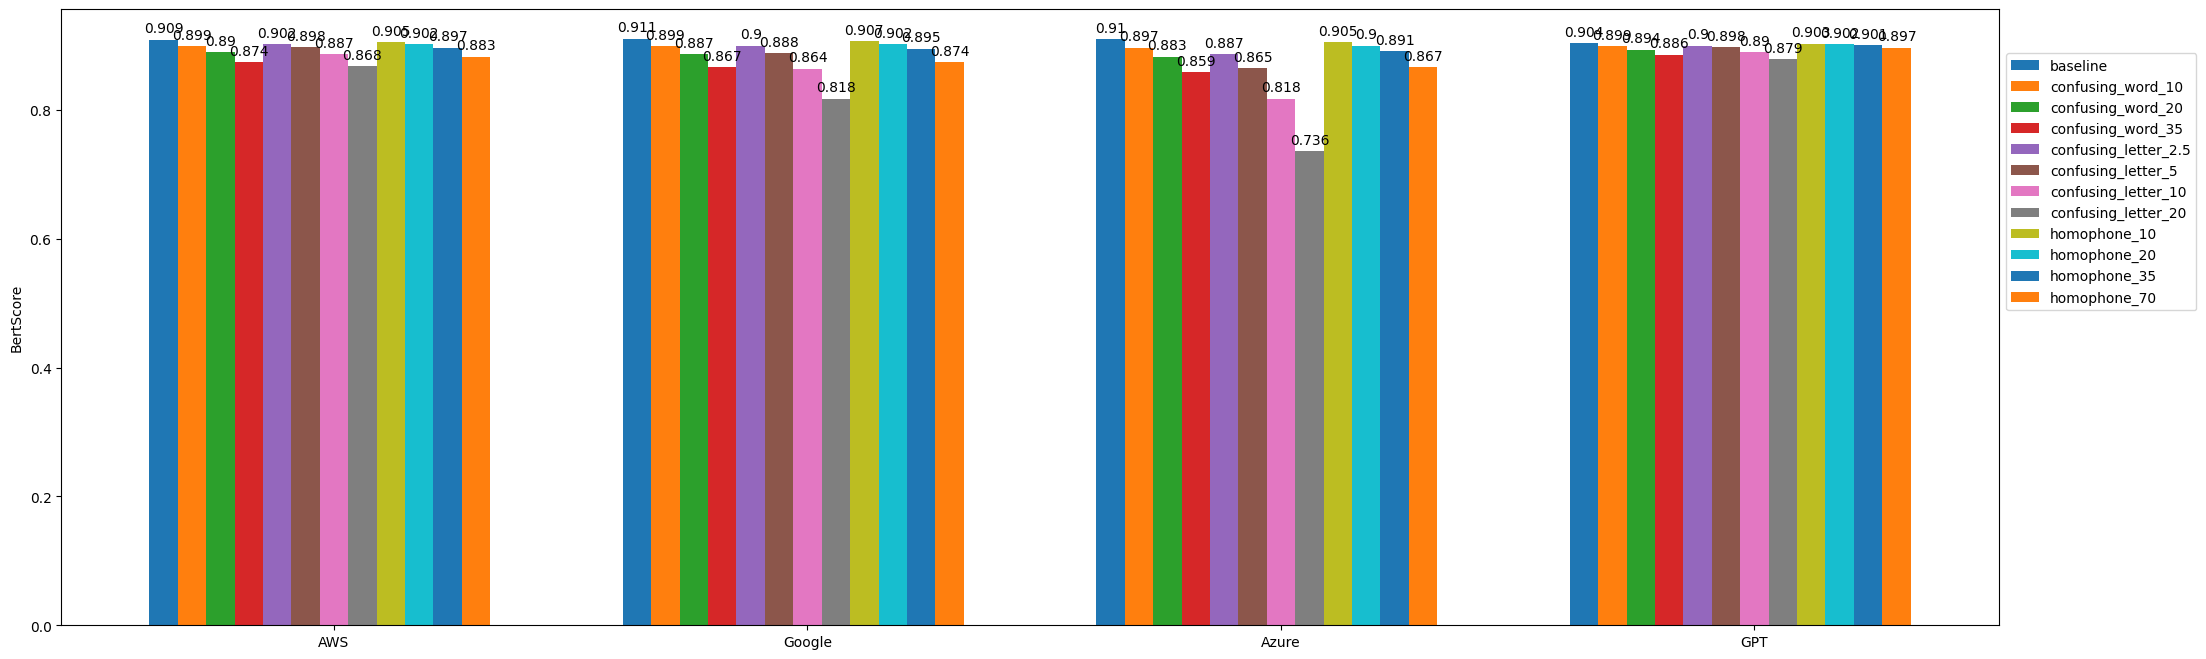

In [11]:
import numpy as np
services = ['AWS', 'Google', 'Azure', 'GPT']
all_data = {
    'baseline': baseline_bert,
    'confusing_word_10': confusing_word_10_bert[0:-1],
    'confusing_word_20': confusing_word_20_bert[0:-1],
    'confusing_word_35': confusing_word_35_bert[0:-1],
    'confusing_letter_2.5': confusing_letter_2_5_bert[0:-1],
    'confusing_letter_5': confusing_letter_5_bert[0:-1],
    'confusing_letter_10': confusing_letter_10_bert[0:-1],
    'confusing_letter_20': confusing_letter_20_bert[0:-1],
    'homophone_10': homophone_10_bert[0:-1],
    'homophone_20': homophone_20_bert[0:-1],
    'homophone_35': homophone_35_bert[0:-1],
    'homophone_70': homophone_70_bert[0:-1]
}
x = np.arange(len(services))
width = 0.06
multiplier = 0

fig, ax = plt.subplots(figsize=(25, 8))

for label, data in all_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, [round(i,3) for i in data], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('BertScore')
#ax.set_title('BLEU Score by Service and Injection Type')
#center the x ticks
ax.set_xticks(x+width*6, services)
#make the lengend outside the plot
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()


In [32]:
#print SE for bert scores
print(f"Baseline: AWS: {baseline_bert_se[0]}, Google: {baseline_bert_se[1]}, Azure: {baseline_bert_se[2]}, GPT: {baseline_bert_se[3]}")
print(f"Confusing Word 10: AWS:{confusing_word_10_bert_se[0]}, Google:{confusing_word_10_bert_se[1]}, Azure:{confusing_word_10_bert_se[2]}, GPT:{confusing_word_10_bert_se[3]}")
print(f"Confusing Word 20: AWS:{confusing_word_20_bert_se[0]}, Google:{confusing_word_20_bert_se[1]}, Azure:{confusing_word_20_bert_se[2]}, GPT:{confusing_word_20_bert_se[3]}")
print(f"Confusing Word 35: AWS:{confusing_word_35_bert_se[0]}, Google:{confusing_word_35_bert_se[1]}, Azure:{confusing_word_35_bert_se[2]}, GPT:{confusing_word_35_bert_se[3]}")
print(f"Confusing Letter 2.5: AWS:{confusing_letter_2_5_bert_se[0]}, Google:{confusing_letter_2_5_bert_se[1]}, Azure:{confusing_letter_2_5_bert_se[2]}, GPT:{confusing_letter_2_5_bert_se[3]}")
print(f"Confusing Letter 5: AWS:{confusing_letter_5_bert_se[0]}, Google:{confusing_letter_5_bert_se[1]}, Azure:{confusing_letter_5_bert_se[2]}, GPT:{confusing_letter_5_bert_se[3]}")
print(f"Confusing Letter 10: AWS:{confusing_letter_10_bert_se[0]}, Google:{confusing_letter_10_bert_se[1]}, Azure:{confusing_letter_10_bert_se[2]}, GPT:{confusing_letter_10_bert_se[3]}")
print(f"Confusing Letter 20: AWS:{confusing_letter_20_bert_se[0]}, Google:{confusing_letter_20_bert_se[1]}, Azure:{confusing_letter_20_bert_se[2]}, GPT:{confusing_letter_20_bert_se[3]}")
print(f"Homophone 10: AWS:{homophone_10_bert_se[0]}, Google:{homophone_10_bert_se[1]}, Azure:{homophone_10_bert_se[2]}, GPT:{homophone_10_bert_se[3]}")
print(f"Homophone 20: AWS:{homophone_20_bert_se[0]}, Google:{homophone_20_bert_se[1]}, Azure:{homophone_20_bert_se[2]}, GPT:{homophone_20_bert_se[3]}")
print(f"Homophone 35: AWS:{homophone_35_bert_se[0]}, Google:{homophone_35_bert_se[1]}, Azure:{homophone_35_bert_se[2]}, GPT:{homophone_35_bert_se[3]}")
print(f"Homophone 70: AWS:{homophone_70_bert_se[0]}, Google:{homophone_70_bert_se[1]}, Azure:{homophone_70_bert_se[2]}, GPT:{homophone_70_bert_se[3]}")


Baseline: AWS:0.09019729303439669, Google:0.08879016185937182, Azure:0.08942703331953687, GPT:0.08920354004239338
Confusing Word 10: AWS:0.09330793408775448, Google:0.09481623927375706, Azure:0.09562379133746621, GPT:0.09179805741329623
Confusing Word 20: AWS:0.09798134075798602, Google:0.09843157786102327, Azure:0.10085588734024634, GPT:0.09449775542754457
Confusing Word 35: AWS:0.10396273632680328, Google:0.10676623129568788, Azure:0.10970773579137803, GPT:0.09838161604548873
Confusing Letter 2.5: AWS:0.09220423515353009, Google:0.09220675463819154, Azure:0.09542322735133635, GPT:0.09011559665035582
Confusing Letter 5: AWS:0.09333243995489517, Google:0.09709448366519646, Azure:0.10288281421900883, GPT:0.09014785660457626
Confusing Letter 10: AWS:0.09656244988918258, Google:0.1065674353527631, Azure:0.11916066672911681, GPT:0.09454322572277764
Confusing Letter 20: AWS:0.10257206903049154, Google:0.1349465549089546, Azure:0.13777445276093547, GPT:0.10429998259288231
Homophone 10: AWS:0

### BertScore SE

No multiplication by 100 (f1 score ranges from 0-1.0)
- Baseline: AWS:0.000901972930343967, Google:0.0008879016185937182, Azure:0.0008942703331953687, GPT:0.0008920354004239339
- Confusing Word 10: AWS:0.0009330793408775447, Google:0.0009481623927375706, Azure:0.0009562379133746621, GPT:0.0009179805741329624
- Confusing Word 20: AWS:0.0009798134075798602, Google:0.0009843157786102329, Azure:0.0010085588734024633, GPT:0.0009449775542754456
- Confusing Word 35: AWS:0.0010396273632680328, Google:0.0010676623129568788, Azure:0.0010970773579137803, GPT:0.0009838161604548874
- Confusing Letter 2.5: AWS:0.0009220423515353008, Google:0.0009220675463819153, Azure:0.0009542322735133634, GPT:0.0009011559665035582
- Confusing Letter 5: AWS:0.0009333243995489518, Google:0.0009709448366519646, Azure:0.0010288281421900881, GPT:0.0009014785660457626
- Confusing Letter 10: AWS:0.0009656244988918259, Google:0.001065674353527631, Azure:0.001191606667291168, GPT:0.0009454322572277764
- Confusing Letter 20: AWS:0.0010257206903049154, Google:0.001349465549089546, Azure:0.0013777445276093548, GPT:0.001042999825928823
- Homophone 10: AWS:0.0009106913852924412, Google:0.0009062500863420536, Azure:0.0009158370145527441, GPT:0.0008932454829567211
- Homophone 20: AWS:0.0009172637227819139, Google:0.0009156521343532965, Azure:0.000927032774095344, GPT:0.000884152127168615
- Homophone 35: AWS:0.0009582046164410939, Google:0.0009648008798737619, Azure:0.0009887050626326322, GPT:0.0008987137017126878
- Homophone 70: AWS:0.0010111718178014706, Google:0.0010677538058419748, Azure:0.0010928692603361274, GPT:0.0009204908345303176`

F1 scores multiplied by 100 (f1 score ranges from 0-100)
- Baseline: AWS:0.09019729303439669, Google:0.08879016185937182, Azure:0.08942703331953687, GPT:0.08920354004239338
- Confusing Word 10: AWS:0.09330793408775448, Google:0.09481623927375706, Azure:0.09562379133746621, GPT:0.09179805741329623
- Confusing Word 20: AWS:0.09798134075798602, Google:0.09843157786102327, Azure:0.10085588734024634, GPT:0.09449775542754457
- Confusing Word 35: AWS:0.10396273632680328, Google:0.10676623129568788, Azure:0.10970773579137803, GPT:0.09838161604548873
- Confusing Letter 2.5: AWS:0.09220423515353009, Google:0.09220675463819154, Azure:0.09542322735133635, GPT:0.09011559665035582
- Confusing Letter 5: AWS:0.09333243995489517, Google:0.09709448366519646, Azure:0.10288281421900883, GPT:0.09014785660457626
- Confusing Letter 10: AWS:0.09656244988918258, Google:0.1065674353527631, Azure:0.11916066672911681, GPT:0.09454322572277764
- Confusing Letter 20: AWS:0.10257206903049154, Google:0.1349465549089546, Azure:0.13777445276093547, GPT:0.10429998259288231
- Homophone 10: AWS:0.09106913852924413, Google:0.09062500863420538, Azure:0.09158370145527443, GPT:0.08932454829567212
- Homophone 20: AWS:0.09172637227819139, Google:0.09156521343532964, Azure:0.0927032774095344, GPT:0.0884152127168615
- Homophone 35: AWS:0.09582046164410937, Google:0.0964800879873762, Azure:0.09887050626326321, GPT:0.08987137017126878
- Homophone 70: AWS:0.10111718178014706, Google:0.10677538058419749, Azure:0.10928692603361276, GPT:0.09204908345303177

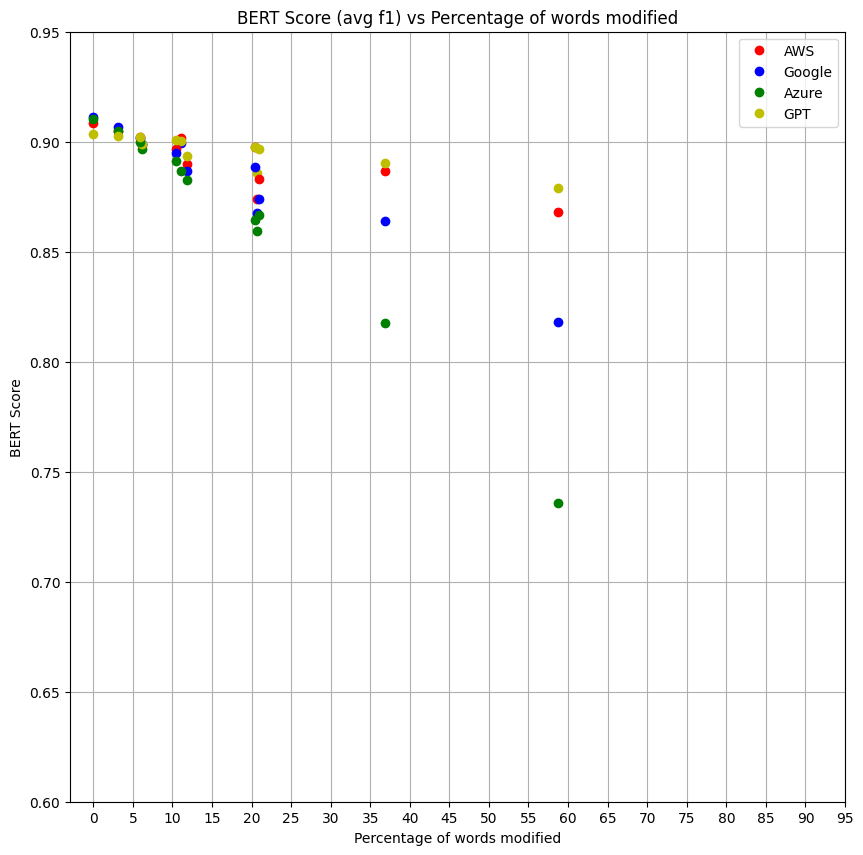

In [21]:
#same as above but for bert_score
all_data = {
    0: baseline_bert,
    confusing_word_10_bert[-1]: confusing_word_10_bert[0:-1],
    confusing_word_20_bert[-1]: confusing_word_20_bert[0:-1],
    confusing_word_35_bert[-1]: confusing_word_35_bert[0:-1],
    confusing_letter_2_5_bert[-1]: confusing_letter_2_5_bert[0:-1],
    confusing_letter_5_bert[-1]: confusing_letter_5_bert[0:-1],
    confusing_letter_10_bert[-1]: confusing_letter_10_bert[0:-1],
    confusing_letter_20_bert[-1]: confusing_letter_20_bert[0:-1],
    confusing_word_35_bert[-1]: confusing_word_35_bert[0:-1],
    homophone_10_bert[-1]: homophone_10_bert[0:-1],
    homophone_20_bert[-1]: homophone_20_bert[0:-1],
    homophone_35_bert[-1]: homophone_35_bert[0:-1],
    homophone_70_bert[-1]: homophone_70_bert[0:-1],
}

fig, ax = plt.subplots(figsize=(10,10))
services =['AWS', 'Google', 'Azure', 'GPT']
colours = ['r', 'b', 'g', 'y']
for x, data in all_data.items():
    counter = 0
    for i in data:
        rects = ax.plot(x, i, marker = 'o',linestyle='', label=services[counter], c=colours[counter])
        counter+=1
ax.set_title('BERT Score (avg f1) vs Percentage of words modified')
ax.set_xlabel('Percentage of words modified')
ax.set_ylabel('BERT Score')
ax.legend(services)

#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.60, 1.0, 0.05))
ax.set_xticks(np.arange(0, 100, 5))
#show grid
ax.grid(True)
plt.show()



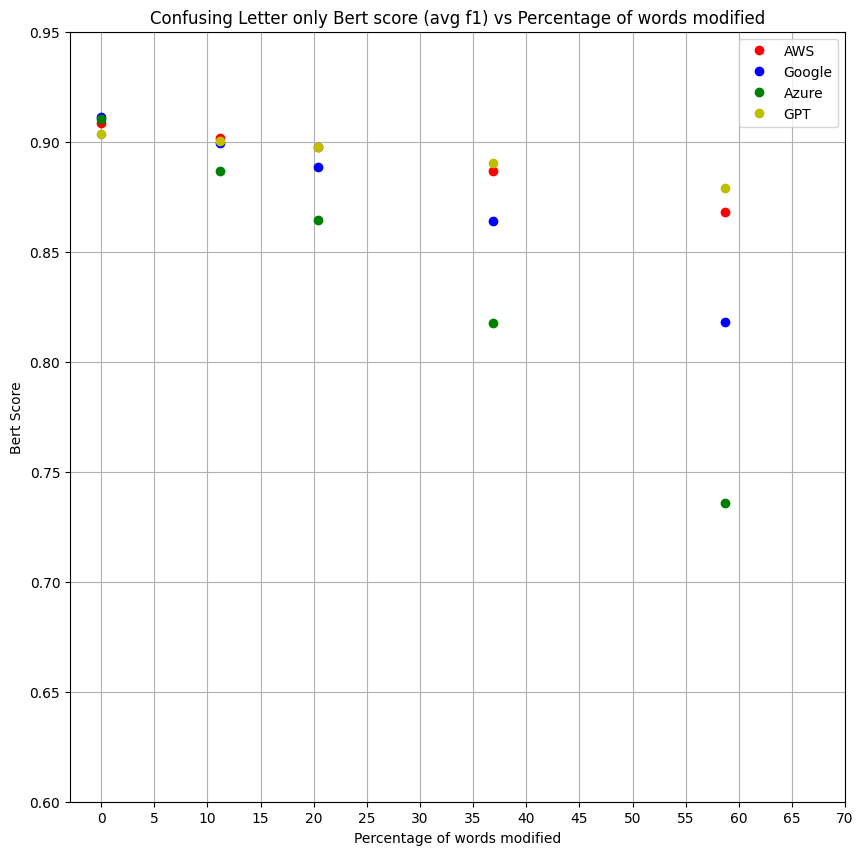

In [22]:
all_data = {
    0: baseline_bert,
    confusing_letter_2_5_bert[-1]: confusing_letter_2_5_bert[0:-1],
    confusing_letter_5_bert[-1]: confusing_letter_5_bert[0:-1],
    confusing_letter_10_bert[-1]: confusing_letter_10_bert[0:-1],
    confusing_letter_20_bert[-1]: confusing_letter_20_bert[0:-1],
}


fig, ax = plt.subplots(figsize=(10,10))
services =['AWS', 'Google', 'Azure', 'GPT']
colours = ['r', 'b', 'g', 'y']
for x, data in all_data.items():
    counter = 0
    for i in data:
        rects = ax.plot(x, i, marker = 'o',linestyle='', label=services[counter], c=colours[counter])
        counter+=1
ax.set_title('Confusing Letter only Bert score (avg f1) vs Percentage of words modified')
ax.set_xlabel('Percentage of words modified')
ax.set_ylabel('Bert Score')
ax.legend(services)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.6, 1, 0.05))
ax.set_xticks(np.arange(0, 75, 5))
#show grid
ax.grid(True)
plt.show()

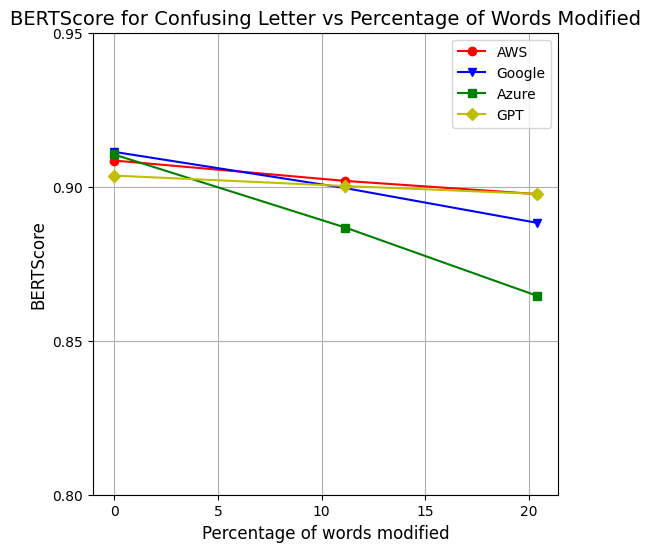

In [40]:
#same as above but for bert score
all_data_2_confusing_letter = {
    'AWS': [baseline_bert[0], confusing_letter_2_5_bert[0], confusing_letter_5_bert[0]],
    'Google': [baseline_bert[1], confusing_letter_2_5_bert[1], confusing_letter_5_bert[1]],
    'Azure': [baseline_bert[2], confusing_letter_2_5_bert[2], confusing_letter_5_bert[2]],
    'GPT': [baseline_bert[3], confusing_letter_2_5_bert[3], confusing_letter_5_bert[3]]

}

fig, ax = plt.subplots(figsize=(6,6))
services =['AWS', 'Google', 'Azure', 'GPT']
word_change_percentage = [0, confusing_letter_2_5_bert[-1], confusing_letter_5_bert[-1]]
colours = ['r', 'b', 'g', 'y']
counter = 0
marker_type = ['o', 'v', 's', 'D']
for x, data in all_data_2_confusing_letter.items():
    rects = ax.plot(word_change_percentage, data, marker =marker_type[counter],linestyle='solid', label=services[counter], c=colours[counter])
    counter+=1
ax.set_title('BERTScore for Confusing Letter vs Percentage of Words Modified', fontsize=14, fontweight='normal')
ax.set_xlabel('Percentage of words modified', fontsize=12, fontweight='normal')
ax.set_ylabel('BERTScore', fontsize=12, fontweight='normal')
ax.legend(services, fontsize=10)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.80, 1, 0.05))
ax.set_xticks(np.arange(0, 21, 5))
#show grid
ax.grid(True)

plt.show()

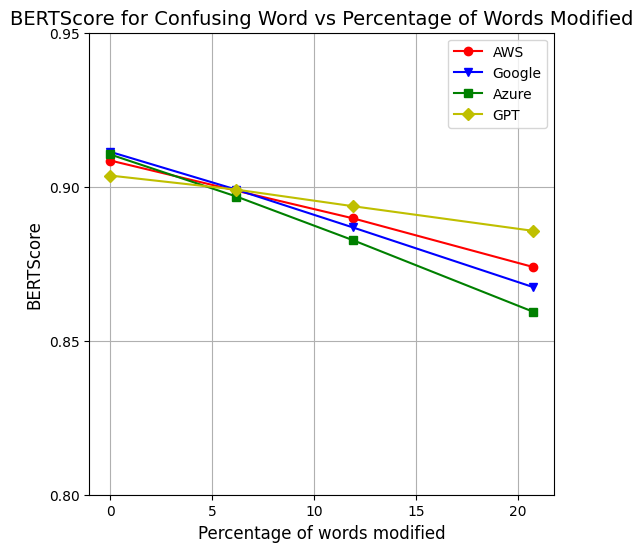

In [41]:
#same as previous but for Confusing word
all_data_2_confusing_word = {
    'AWS': [baseline_bert[0], confusing_word_10_bert[0], confusing_word_20_bert[0], confusing_word_35_bert[0]],
    'Google': [baseline_bert[1], confusing_word_10_bert[1], confusing_word_20_bert[1], confusing_word_35_bert[1]],
    'Azure': [baseline_bert[2], confusing_word_10_bert[2], confusing_word_20_bert[2], confusing_word_35_bert[2]],
    'GPT': [baseline_bert[3], confusing_word_10_bert[3], confusing_word_20_bert[3], confusing_word_35_bert[3]],

}

fig, ax = plt.subplots(figsize=(6,6))
services =['AWS', 'Google', 'Azure', 'GPT']
word_change_percentage = [0, confusing_word_10_bert[-1], confusing_word_20_bert[-1], confusing_word_35_bert[-1]]
colours = ['r', 'b', 'g', 'y']
counter = 0
marker_type = ['o', 'v', 's', 'D']
for x, data in all_data_2_confusing_word.items():
    rects = ax.plot(word_change_percentage, data, marker =marker_type[counter],linestyle='solid', label=services[counter], c=colours[counter])
    counter+=1
ax.set_title('BERTScore for Confusing Word vs Percentage of Words Modified', fontsize=14, fontweight='normal')
ax.set_xlabel('Percentage of words modified', fontsize=12, fontweight='normal')
ax.set_ylabel('BERTScore', fontsize=12, fontweight='normal')
ax.legend(services, fontsize=10)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.80, 1, 0.05))
ax.set_xticks(np.arange(0, 21, 5))
#show grid
ax.grid(True)

plt.show()

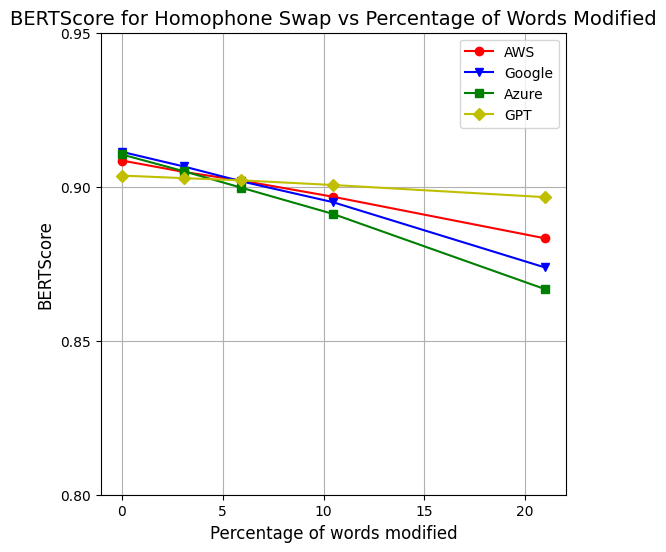

In [45]:
#same for homophone swapping

all_data_2_homophone = {
    'AWS': [baseline_bert[0], homophone_10_bert[0], homophone_20_bert[0], homophone_35_bert[0], homophone_70_bert[0]],
    'Google': [baseline_bert[1], homophone_10_bert[1], homophone_20_bert[1], homophone_35_bert[1], homophone_70_bert[1]],
    'Azure': [baseline_bert[2], homophone_10_bert[2], homophone_20_bert[2], homophone_35_bert[2], homophone_70_bert[2]],
    'GPT': [baseline_bert[3], homophone_10_bert[3], homophone_20_bert[3], homophone_35_bert[3], homophone_70_bert[3]],

}

fig, ax = plt.subplots(figsize=(6,6))
services =['AWS', 'Google', 'Azure', 'GPT']
word_change_percentage = [0, homophone_10_bert[-1], homophone_20_bert[-1], homophone_35_bert[-1], homophone_70_bert[-1]]
colours = ['r', 'b', 'g', 'y']
counter = 0

for x, data in all_data_2_homophone.items():
    rects = ax.plot(word_change_percentage, data, marker =marker_type[counter],linestyle='solid', label=services[counter], c=colours[counter])
    counter+=1
ax.set_title('BERTScore for Homophone Swap vs Percentage of Words Modified', fontsize=14, fontweight='normal')
ax.set_xlabel('Percentage of words modified', fontsize=12, fontweight='normal')
ax.set_ylabel('BERTScore', fontsize=12, fontweight='normal')
ax.legend(services, fontsize=10)

#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.80, 1, 0.05))
ax.set_xticks(np.arange(0, 22, 5))
#show grid
ax.grid(True)
plt.show()

